# DeepDispatch — Revenue Class Prediction
### Logistic Regression Baseline with Ordinal-Aware Evaluation

**Project:** CPSC 5310  
**Target:** `revenue_class` — ordinal 5-class label (1: Zero → 5: Elite)  
**Model:** Logistic Regression (Multinomial)

---

### Hyperparameter Note

Best `C` value identified from prior randomized search: **`C = 0.1329`**  
This is used directly — no search is rerun.

## 1. Imports & Configuration

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import loguniform

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    f1_score,
)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler



# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
BEST_C = 0.13292918943162169

# Plot defaults
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

print("Imports complete.")

Imports complete.


## 2. Environment Setup (Google Colab)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

DATA_PATH   = "/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/"
OUTPUT_PATH = "/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/"
MODELS_PATH = "/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/"

os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Output directory ready: {OUTPUT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output directory ready: /content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/


## 3. Data Loading & Validation

In [3]:
train_df = pd.read_parquet(DATA_PATH + "baseline_training.parquet")
test_df  = pd.read_parquet(DATA_PATH + "baseline_testing.parquet")

print(f"Train shape : {train_df.shape}")
print(f"Test  shape : {test_df.shape}")
print(f"\nClass distribution (train):")
print(train_df["revenue_class"].value_counts().sort_index())

Train shape : (233850, 44)
Test  shape : (39445, 44)

Class distribution (train):
revenue_class
1    26850
2    51162
3    51092
4    51808
5    52938
Name: count, dtype: int64


In [4]:
# Confirm no nulls — model will fail silently with NaNs otherwise
null_counts = train_df.isnull().sum()
assert null_counts.sum() == 0, f"Unexpected nulls:\n{null_counts[null_counts > 0]}"
print("No null values detected in training data.")

No null values detected in training data.


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233850 entries, 0 to 233849
Data columns (total 44 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pickup_cluster                      233850 non-null  int64         
 1   timestamp                           233850 non-null  datetime64[ns]
 2   demand_count                        233850 non-null  float64       
 3   total_engaged_minutes               233850 non-null  float64       
 4   speed_mph                           233850 non-null  float64       
 5   airport_trip_count                  233850 non-null  float64       
 6   profit_index                        233850 non-null  float64       
 7   revenue_class                       233850 non-null  int64         
 8   day_of_week                         233850 non-null  int32         
 9   hour                                233850 non-null  int32         
 10  hour_sin

## 4. Feature Engineering & Target Definition

In [6]:
TARGET_COL = "revenue_class"
COLS_TO_EXCLUDE = [TARGET_COL, "timestamp", "hour", "day_of_week"]

X_train = train_df.drop(columns=COLS_TO_EXCLUDE)
y_train = train_df[TARGET_COL]

X_test  = test_df.drop(columns=COLS_TO_EXCLUDE)
y_test  = test_df[TARGET_COL]

print(f"Feature count : {X_train.shape[1]}")
print(f"Classes       : {sorted(y_train.unique())}")

Feature count : 40
Classes       : [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [7]:
# Feature type separation
# pickup_cluster is a nominal categorical ID — it must NOT be scaled numerically.
CATEGORICAL_FEATURES = ["pickup_cluster"]
NUMERIC_FEATURES = [
    col for col in X_train.select_dtypes(include=np.number).columns
    if col not in CATEGORICAL_FEATURES
]

print(f"Numeric features    : {len(NUMERIC_FEATURES)}")
print(f"Categorical features: {CATEGORICAL_FEATURES}")

Numeric features    : 39
Categorical features: ['pickup_cluster']


## 5. Pipeline

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_FEATURES),
        ('cat', TargetEncoder(random_state=RANDOM_STATE), CATEGORICAL_FEATURES),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=BEST_C,               # best value from prior randomized search
        solver='saga',          # fastest for large datasets
        max_iter=500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['demand_count',
                                                   'total_engaged_minutes',
                                                   'speed_mph',
                                                   'airport_trip_count',
                                                   'profit_index', 'hour_sin',
                                                   'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos',
                                                   'is_weekend', 'is_blizzard',
                                                   'demand_count_lag_1',
                                                   'demand_count_lag_2',
                                                   'demand_count_lag_24',
                                                   'demand_count_lag_168',
                                                   'r...
                                                   'airport_trip_count_lag_24',
                                                   'airport_trip_count_lag_168',
                                                   'demand_count_rolling_mean_3',
                                                   'demand_count_rolling_mean_8',
                                                   'demand_count_rolling_mean_24', ...]),
                                                 ('cat',
                                                  TargetEncoder(random_state=42),
                                                  ['pickup_cluster'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=0.13292918943162169, max_iter=500,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

## 6. Model Training

In [9]:
import time

t0 = time.time()
full_pipeline.fit(X_train, y_train)
train_time = time.time() - t0

## 7. Evaluation

| Metric | What it measures | Target |
|--------|-----------------|--------|
| **Accuracy** | % exact correct predictions | — |
| **MAE** | Average ordinal distance between true and predicted class | ≤ 0.80 |
| **Adjacent Accuracy (±1)** | % predictions within 1 class of truth | ≥ 90% |
| **Weighted F1** | F1 averaged by class support, accounts for imbalance | ≥ 0.75 |

In [10]:
CLASS_LABELS = ["1: Very Low", "2: Low", "3: Medium", "4: High", "5: Surge"]

y_pred = full_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_mae      = mean_absolute_error(y_test, y_pred)
adjacent_acc  = np.mean(np.abs(y_test - y_pred) <= 1)
weighted_f1   = f1_score(y_test, y_pred, average='weighted')

print('=' * 60)
print('  Test Set Evaluation — Logistic Regression (Baseline)')
print('=' * 60)
print(f'  Accuracy               : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  MAE (ordinal)          : {test_mae:.4f}   [target: ≤ 0.80]')
print(f'  Adjacent Accuracy (±1) : {adjacent_acc:.4f} ({adjacent_acc*100:.2f}%)  [target: ≥ 90%]')
print(f'  Weighted F1            : {weighted_f1:.4f}   [target: ≥ 0.75]')
print('=' * 60)
print()
print('Per-class Report:')
print(classification_report(y_test, y_pred, target_names=CLASS_LABELS))

  Test Set Evaluation — Logistic Regression (Baseline)
  Accuracy               : 0.7536 (75.36%)
  MAE (ordinal)          : 0.2513   [target: ≤ 0.80]
  Adjacent Accuracy (±1) : 0.9961 (99.61%)  [target: ≥ 90%]
  Weighted F1            : 0.7522   [target: ≥ 0.75]

Per-class Report:
              precision    recall  f1-score   support

 1: Very Low       0.73      0.56      0.63      2753
      2: Low       0.73      0.79      0.75      8705
   3: Medium       0.72      0.69      0.71      9755
     4: High       0.72      0.73      0.73      9462
    5: Surge       0.86      0.87      0.86      8770

    accuracy                           0.75     39445
   macro avg       0.75      0.73      0.74     39445
weighted avg       0.75      0.75      0.75     39445



## 8. Confusion Matrix

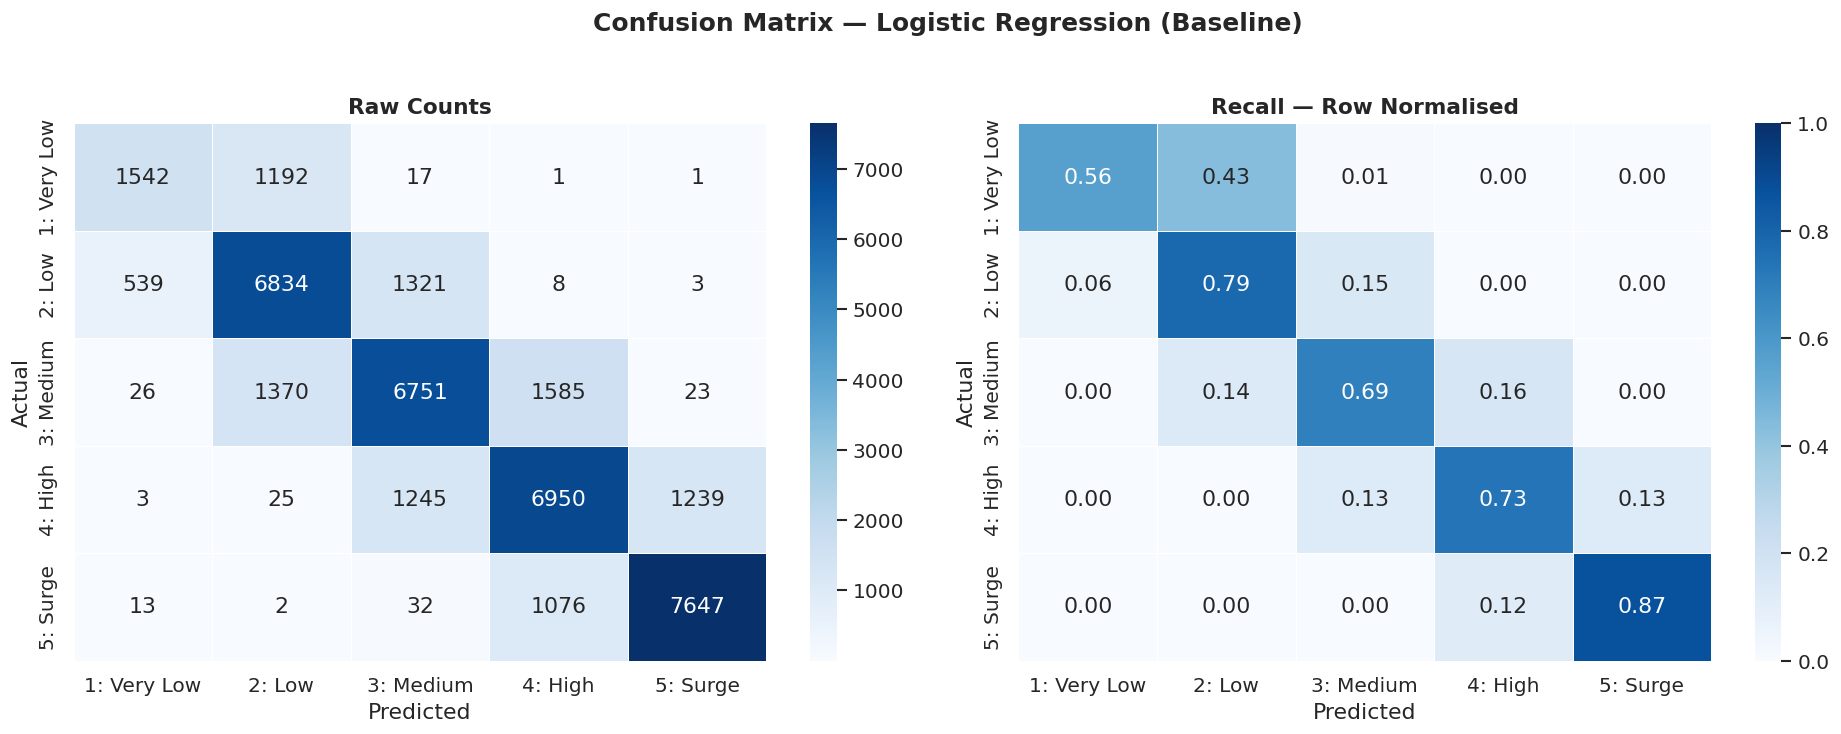

In [11]:
cm      = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
            ax=axes[0], linewidths=0.5)
axes[0].set_title('Raw Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
            ax=axes[1], linewidths=0.5, vmin=0, vmax=1)
axes[1].set_title('Recall — Row Normalised', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrix — Logistic Regression (Baseline)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Coefficient Analysis (Feature Importance)

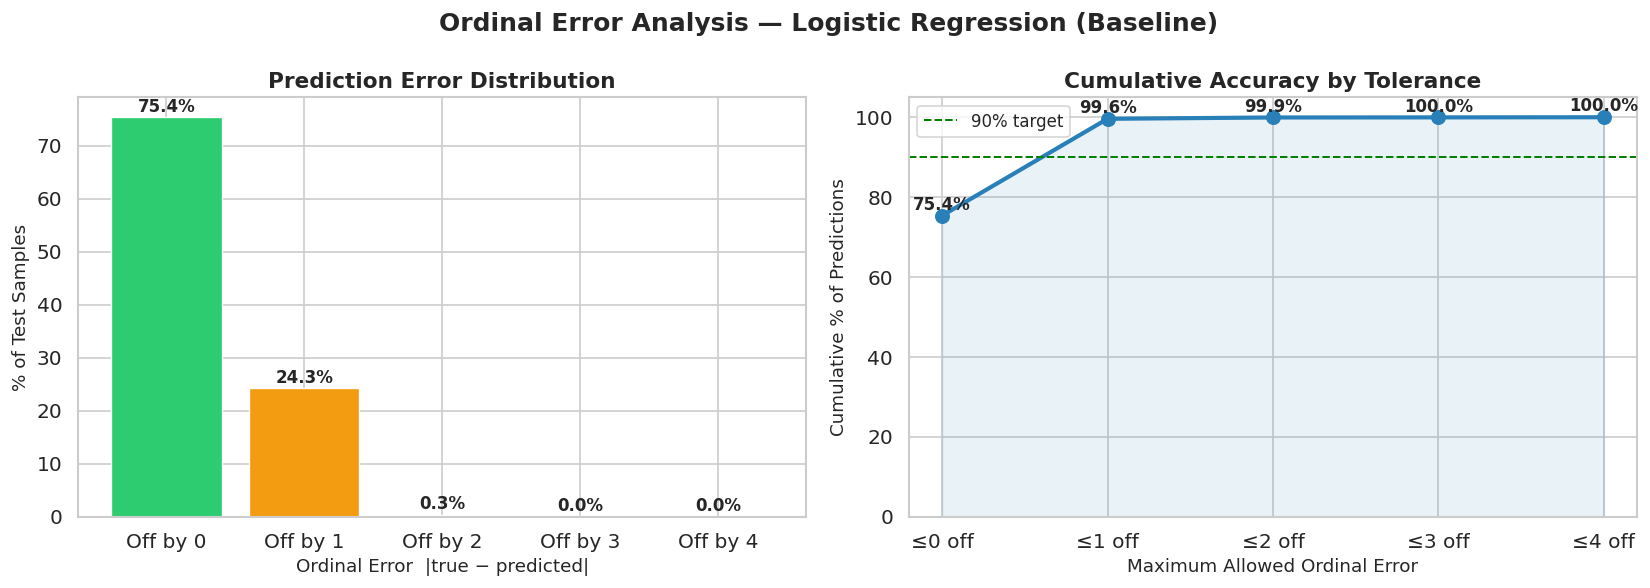

  Exact match       : 75.4%
  Within ±1 class   : 99.6%
  Within ±2 classes : 99.9%


In [12]:
errors       = np.abs(y_test.values - y_pred)
error_counts = pd.Series(errors).value_counts().sort_index()
error_pct    = error_counts / len(errors) * 100
cum_pct      = error_pct.cumsum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

palette = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
bars = axes[0].bar(error_pct.index, error_pct.values,
                   color=palette[:len(error_pct)], edgecolor='white', linewidth=0.8)
axes[0].set_xlabel('Ordinal Error  |true − predicted|', fontsize=11)
axes[0].set_ylabel('% of Test Samples', fontsize=11)
axes[0].set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(error_pct.index)
axes[0].set_xticklabels([f'Off by {i}' for i in error_pct.index])
for bar, pct in zip(bars, error_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].plot(cum_pct.index, cum_pct.values, marker='o', color='#2980b9',
             linewidth=2.5, markersize=8)
axes[1].axhline(90, color='green', linestyle='--', linewidth=1.2, label='90% target')
axes[1].fill_between(cum_pct.index, cum_pct.values, alpha=0.1, color='#2980b9')
axes[1].set_xlabel('Maximum Allowed Ordinal Error', fontsize=11)
axes[1].set_ylabel('Cumulative % of Predictions', fontsize=11)
axes[1].set_title('Cumulative Accuracy by Tolerance', fontsize=13, fontweight='bold')
axes[1].set_xticks(cum_pct.index)
axes[1].set_xticklabels([f'≤{i} off' for i in cum_pct.index])
axes[1].set_ylim(0, 105)
axes[1].legend(fontsize=10)
for x, y in zip(cum_pct.index, cum_pct.values):
    axes[1].text(x, y + 1.5, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Ordinal Error Analysis — Logistic Regression (Baseline)',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'  Exact match       : {error_pct.get(0, 0):.1f}%')
print(f'  Within ±1 class   : {cum_pct.get(1, 0):.1f}%')
print(f'  Within ±2 classes : {cum_pct.get(2, 0):.1f}%')

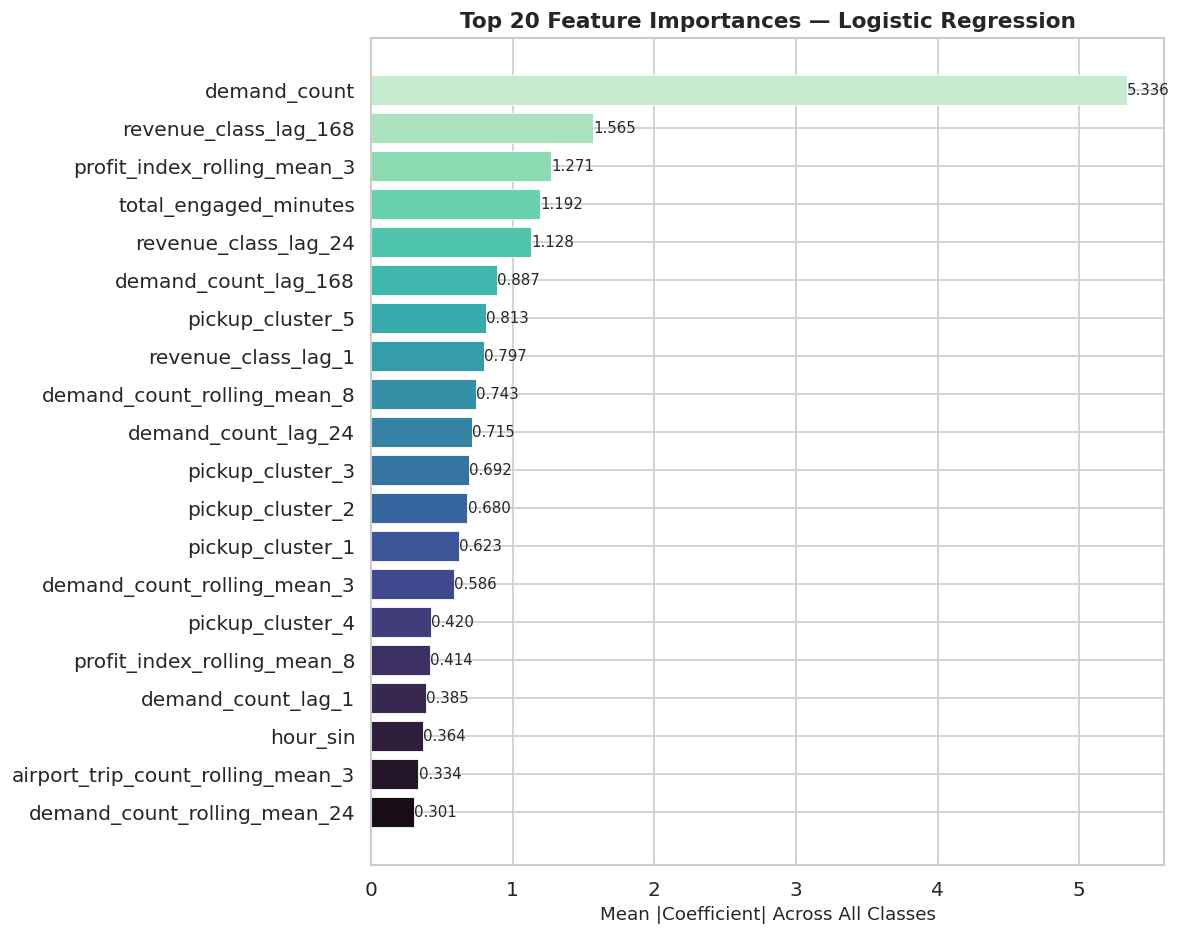

In [13]:
feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients shape: (n_classes, n_features)
coef_matrix = full_pipeline.named_steps['classifier'].coef_
coef_df = pd.DataFrame(
    coef_matrix,
    index=[f'Class {i+1}' for i in range(5)],
    columns=feature_names,
).T

# Overall importance = mean absolute coefficient across all classes
coef_df['mean_abs'] = coef_df.abs().mean(axis=1)
top_features = coef_df['mean_abs'].nlargest(20).index

TOP_N   = 20
imp_df  = coef_df['mean_abs'].nlargest(TOP_N)
colors  = sns.color_palette("mako", n_colors=TOP_N)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(imp_df.index[::-1], imp_df.values[::-1],
               color=colors, edgecolor='white', linewidth=0.5)
for bar, val in zip(bars, imp_df.values[::-1]):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

ax.set_xlabel('Mean |Coefficient| Across All Classes', fontsize=11)
ax.set_title(f'Top {TOP_N} Feature Importances — Logistic Regression',
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

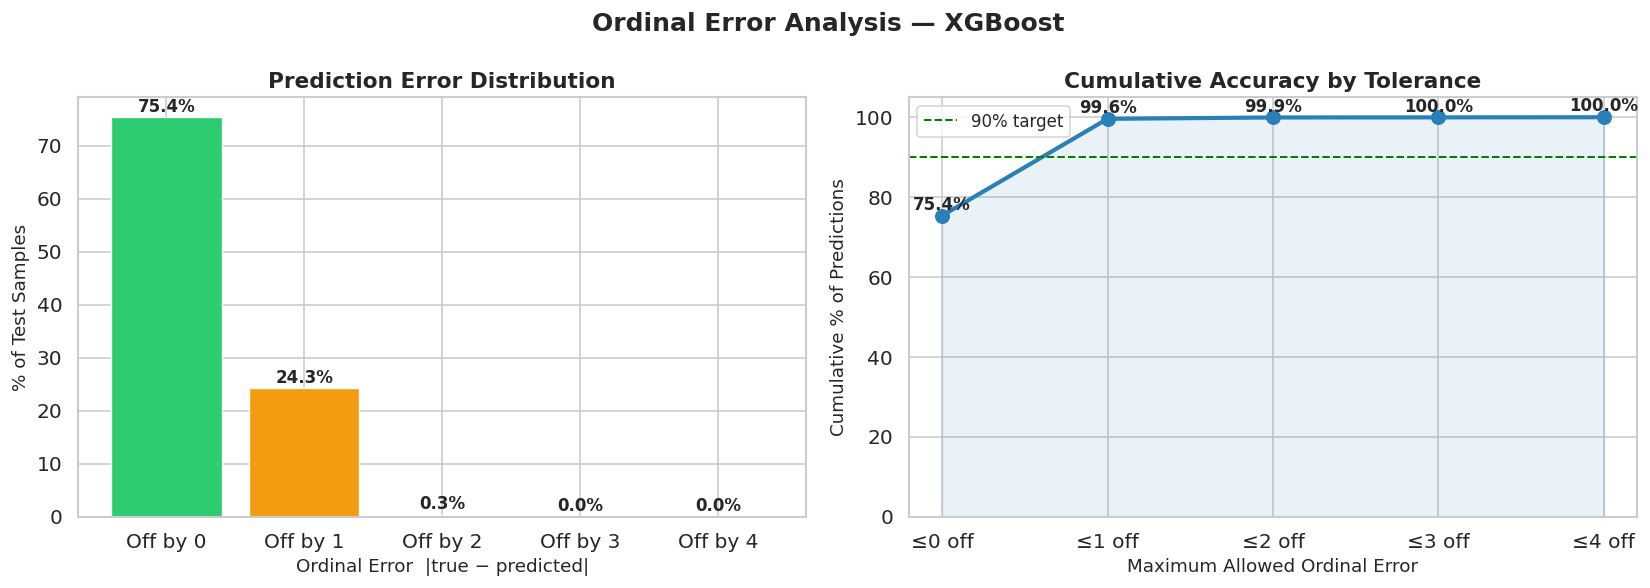

  Exact match       : 75.4%
  Within ±1 class   : 99.6%
  Within ±2 classes : 99.9%


In [14]:
errors       = np.abs(y_test.values - y_pred)
error_counts = pd.Series(errors).value_counts().sort_index()
error_pct    = error_counts / len(errors) * 100
cum_pct      = error_pct.cumsum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

palette = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
bars = axes[0].bar(
    error_pct.index, error_pct.values,
    color=palette[:len(error_pct)], edgecolor='white', linewidth=0.8
)
axes[0].set_xlabel('Ordinal Error  |true − predicted|', fontsize=11)
axes[0].set_ylabel('% of Test Samples', fontsize=11)
axes[0].set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(error_pct.index)
axes[0].set_xticklabels([f'Off by {i}' for i in error_pct.index])
for bar, pct in zip(bars, error_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].plot(cum_pct.index, cum_pct.values, marker='o', color='#2980b9',
             linewidth=2.5, markersize=8)
axes[1].axhline(90, color='green', linestyle='--', linewidth=1.2, label='90% target')
axes[1].fill_between(cum_pct.index, cum_pct.values, alpha=0.1, color='#2980b9')
axes[1].set_xlabel('Maximum Allowed Ordinal Error', fontsize=11)
axes[1].set_ylabel('Cumulative % of Predictions', fontsize=11)
axes[1].set_title('Cumulative Accuracy by Tolerance', fontsize=13, fontweight='bold')
axes[1].set_xticks(cum_pct.index)
axes[1].set_xticklabels([f'≤{i} off' for i in cum_pct.index])
axes[1].set_ylim(0, 105)
axes[1].legend(fontsize=10)
for x, y in zip(cum_pct.index, cum_pct.values):
    axes[1].text(x, y + 1.5, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Ordinal Error Analysis — XGBoost', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'  Exact match       : {error_pct.get(0, 0):.1f}%')
print(f'  Within ±1 class   : {cum_pct.get(1, 0):.1f}%')
print(f'  Within ±2 classes : {cum_pct.get(2, 0):.1f}%')

## 11. Save Model

In [15]:
model_save_path = MODELS_PATH + 'logreg_best_model.pkl'
joblib.dump(full_pipeline, model_save_path)

['/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/logreg_best_model.pkl']